# NumTopics: PScience

In [1]:
import time

from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.dataset import Dataset

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import sys

sys.path.insert(0, '..')

from run_search import (
    _optimize_scores,
    _build_renyi_entropy_score,
    _build_perplexity_score
)

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.scores import (
    PerplexityScore,
    EntropyScore
)
from topnum.search_methods.optimize_scores_method import OptimizeScoresMethod
from topnum.search_methods.optimize_scores_method import restore_failed_experiment

## Data

In [2]:
PATH = '/data/datasets/Post_Science/PScience.csv'
BATCHES = './PScience_batches'

dataset = Dataset(PATH, batch_vectorizer_path=BATCHES)

In [3]:
modalities = {
    "@word": 1.0,
    "@post_tag": 3,
    "@3gramm": 3,
}

In [5]:
vw_file_path = "PScience_vw.txt"

dataset.write_vw(vw_file_path)

In [6]:
# TODO: instead of modalities let's use predefined model families
# TODO: output_file_path

## Experiments

In [7]:
main_modality_name, modalities = "@word", modalities

modality_names = list(modalities.keys())

# vw_file_path = args.vw_file_path

output_file_path = "output.json"

min_num_topics = 13
max_num_topics = 25

num_topics_interval = 1
num_fit_iterations = 10
num_restarts = 6

In [8]:
threshold_factor = 1

scores = [_build_renyi_entropy_score(threshold_factor, modality_names)]

In [59]:
scores[0].name

'renyi_entropy_score'

In [10]:
text_collection = VowpalWabbitTextCollection(
    vw_file_path,
    main_modality=main_modality_name,
    modalities=modalities
)

optimizer = OptimizeScoresMethod(
    scores=scores,
    min_num_topics=min_num_topics,
    max_num_topics=max_num_topics,
    num_topics_interval=num_topics_interval,
    num_fit_iterations=num_fit_iterations,
    num_restarts=num_restarts,
    experiment_name="num_topics_search_10iters"
)

In [ ]:
t_start = time.time()

optimizer.search_for_optimum(text_collection)

In [ ]:
result, detailed_resut = restore_failed_experiment('num_topics_search', 'num_topics_search_10iters', ["renyi_entropy_score"])

In [101]:
detailed_resut['renyi_entropy_score']

,13,14,15,16,17,18,19,20,21,22,23,24,25
restart_id,,,,,,,,,,,,,
seed=0,1.742720,1.746169,1.743445,1.737934,1.740811,1.741401,1.742094,1.743911,1.748436,1.752369,1.756215,1.755854,1.757148
seed=1,1.729368,1.733189,1.735929,1.739742,1.737735,1.738726,1.739136,1.744090,1.744311,1.747291,1.753374,1.755947,1.757525
seed=2,1.731936,1.732251,1.729011,1.727693,1.727476,1.735090,1.735419,1.738627,1.742005,1.745690,1.746900,1.751988,1.754505
seed=3,1.730542,1.728916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seed=-1,1.742720,1.746169,1.743445,1.737934,1.740811,1.741401,1.742094,1.743911,1.748436,1.752369,1.756215,1.755854,1.757148


In [102]:
result['score_results']['renyi_entropy_score']

{'optimum': 16.0,
 'optimum_std': 1.6431676725154982,
 'num_topics_values': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
 'score_values': [1.7354574325305752,
  1.7373386481894268,
  1.7379571649737604,
  1.7358259976978723,
  1.7367085805293891,
  1.739154704318309,
  1.7396857541532964,
  1.7426349337928837,
  1.745797080592478,
  1.749429804469732,
  1.7531761629770546,
  1.7549108509613665,
  1.7565815260077826],
 'score_values_std': [0.006691990321398389,
  0.00821603728864417,
  0.006937391277315459,
  0.005488225301487853,
  0.00632359343596722,
  0.002988738429395719,
  0.0031678907377335496,
  0.0026730171541445107,
  0.003189580008400131,
  0.003456549694349441,
  0.004393182645154352,
  0.0019489083042670099,
  0.0013959244734553526]}

The minimum of entropy appears to be near 15-20 topics

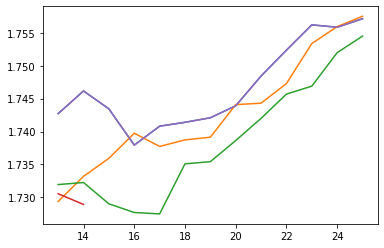

In [100]:
plt.plot(detailed_resut['renyi_entropy_score'].T)
plt.show()